In [1]:
# Method 1 Remvoe small and remove larger

In [21]:
#define variable
left = 280
right = 1000
up = 620
down = 690
language = "thai"
image_path = "01.png"
font_width = (3,9)
stroke_width = 7
inpaint_width = 7

In [2]:
#เตรียมการ library
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 30
print(cv2.__version__)

3.3.0


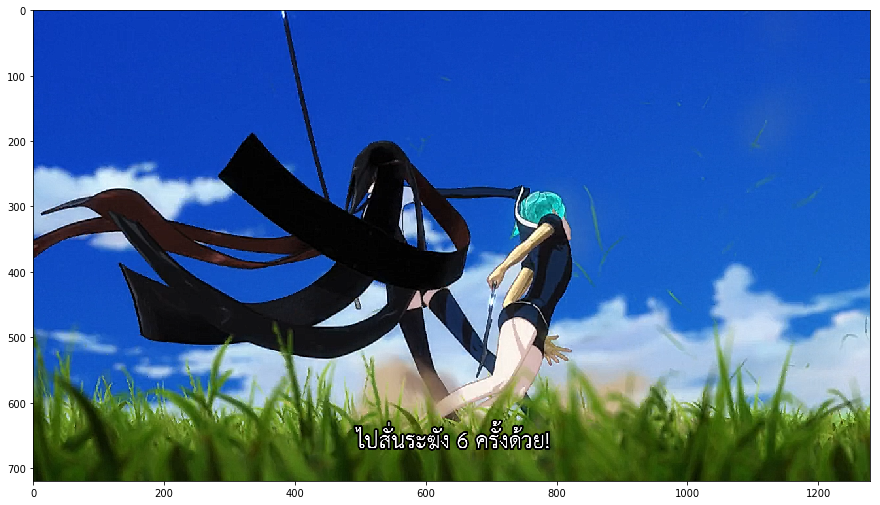

In [4]:
#โหลดรูปภาพต้นฉบับ
subtitle_image = cv2.imread(language+"/"+image_path)
subtitle_image = cv2.cvtColor(subtitle_image, cv2.COLOR_BGR2RGB) # cv2 use bgr but plt use rgb
plt.imshow(subtitle_image)
plt.show()

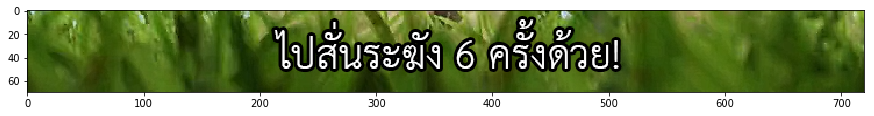

In [5]:
#ตัดเฟรมเฉพาะส่วนที่เป็นข้อความ
subtitle_frame = subtitle_image[up:down,left:right]
plt.imshow(subtitle_frame)
plt.show()

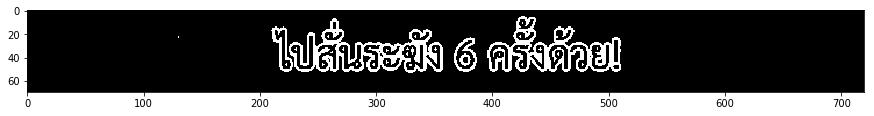

In [6]:
#เลือกสีดำ
black_mask = cv2.inRange(subtitle_frame, (0,0,0), (30,30,30))
plt.imshow(black_mask,cmap = plt.cm.gray)
plt.show()

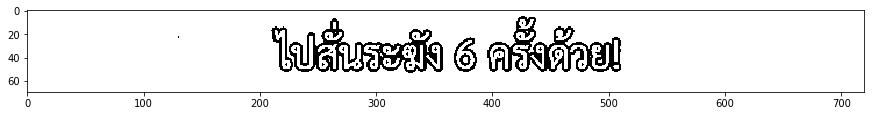

In [7]:
#สลับสีเพื่อเตรียมการเคลียของทิ้ง
inverted_mask = cv2.bitwise_not(black_mask)
plt.imshow(inverted_mask,cmap = plt.cm.gray)
plt.show()

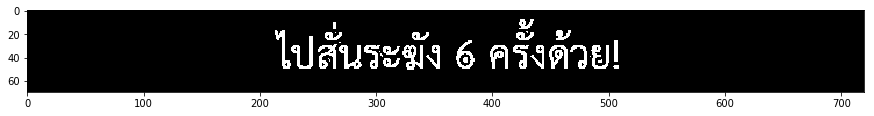

In [8]:
#ทำการถมดำ
cavity_mask = inverted_mask.copy()
height,width = inverted_mask.shape
mask_flood = np.zeros((height+2, width+2), np.uint8) #require by OpenCV spec but doesn't not affact
for y in range(0,height):
    cv2.floodFill(cavity_mask,mask_flood,(0,y),0)
    cv2.floodFill(cavity_mask,mask_flood,(width-1,y),0)
for x in range(0,width):
    cv2.floodFill(cavity_mask,mask_flood,(x,0),0)
    cv2.floodFill(cavity_mask,mask_flood,(x,height-1),0)
plt.imshow(cavity_mask,cmap = plt.cm.gray)
plt.show()

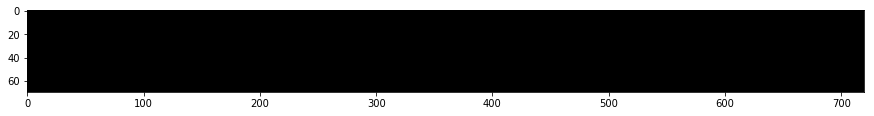

In [9]:
#หาพื้นที่ใหญ่เกินไปในภาพ
large_object = cv2.erode(cavity_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(font_width[1],font_width[1])))
plt.imshow(large_object,cmap = plt.cm.gray)
plt.show()

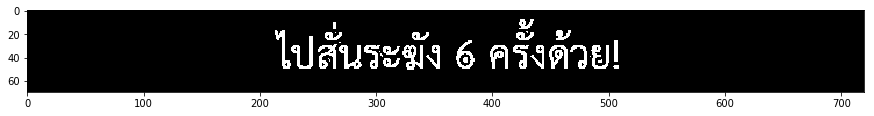

In [10]:
#ถมวัตถุที่ใหญ่เกินไป
mask_flood_object = np.zeros((height+2, width+2), np.uint8) 
mask_flood_canvas = np.zeros((height+2, width+2), np.uint8) 
large_object_canvas = large_object.copy()
cavity_with_noise = cavity_mask.copy()
for y in range(0,height):
    for x in range(0,width):
        if large_object_canvas[y][x] == 255:
            cv2.floodFill(large_object_canvas,mask_flood_object,(x,y),0)
            cv2.floodFill(cavity_with_noise,mask_flood_canvas,(x,y),0)
plt.imshow(cavity_with_noise,cmap = plt.cm.gray)
plt.show()

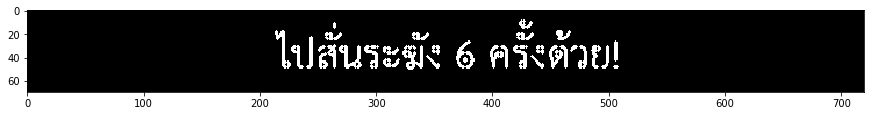

In [11]:
#ลบพื้นที่เล็กเกินไปออกจากภาพ
cavity_no_noise = cv2.morphologyEx(cavity_with_noise, cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(font_width[0],font_width[0])))
plt.imshow(cavity_no_noise,cmap = plt.cm.gray)
plt.show()

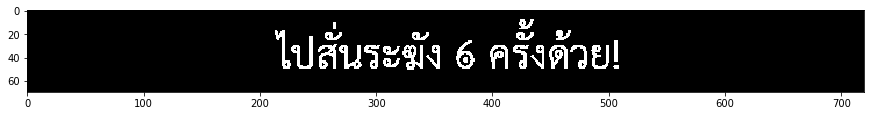

In [12]:
#ใช้ connected component labeling เพื่อเอาส่วนที่ต้องการโดยไม่ให้ตัวอักษรเสียหายมากนัก
nonoise = cavity_no_noise.copy()
noisy = cavity_with_noise.copy()
mask_flood_nonoise = np.zeros((height+2, width+2), np.uint8) 
mask_flood_noisy = np.zeros((height+2, width+2), np.uint8) 
for y in range(0,height):
    for x in range(0,width):
        if nonoise[y][x] == 255:
            cv2.floodFill(nonoise,mask_flood_nonoise,(x,y),0)
            cv2.floodFill(noisy,mask_flood_noisy,(x,y),0)
result_mask = mask_flood_noisy[1:height+1,1:width+1]
plt.imshow(result_mask,cmap = plt.cm.gray)
plt.show()

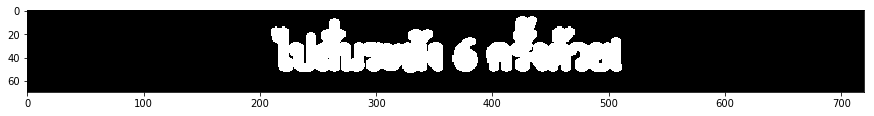

In [26]:
subtitle_stoke = cv2.dilate(result_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(stroke_width,stroke_width))) 
plt.imshow(subtitle_stoke,cmap = plt.cm.gray)
plt.show() #save_stoke

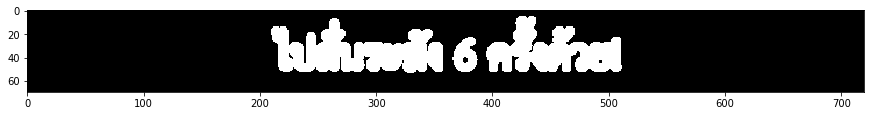

In [27]:
#เรียก domain เข้ามา
domain_image = cv2.imread("mask_"+language+"/"+image_path)
domain_image = cv2.cvtColor(domain_image, cv2.COLOR_BGR2RGB) 
domain_frame = domain_image[up:down,left:right]
domain_mask = cv2.bitwise_not(cv2.inRange(domain_frame, (0,225,0), (30,255,30)))
plt.imshow(domain_mask,cmap = plt.cm.gray)
plt.show()

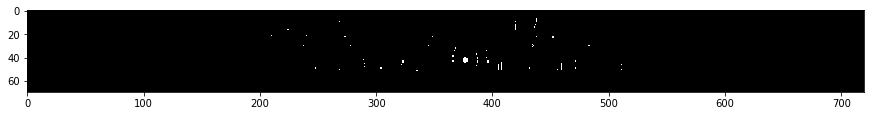

In [28]:
#เทียบส่วนต่าง
reverse_domain_mask = cv2.bitwise_not(domain_mask)
compare_domain = cv2.bitwise_and(reverse_domain_mask,subtitle_stoke)
plt.imshow(compare_domain,cmap = plt.cm.gray)
plt.show() #save_diff

In [16]:
#นับจำนวนส่วนต่างทั้งหมด
print(cv2.countNonZero(compare_domain)) 

92


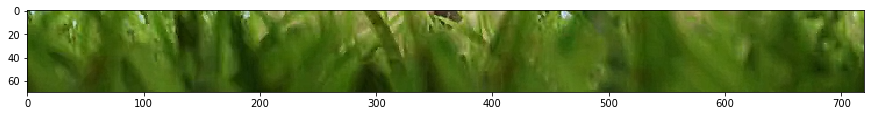

In [17]:
#เรียกเฟรมจริงเข้ามา
original_image = cv2.imread("original/"+image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) 
original_frame = original_image[up:down,left:right]
plt.imshow(original_frame)
plt.show() 

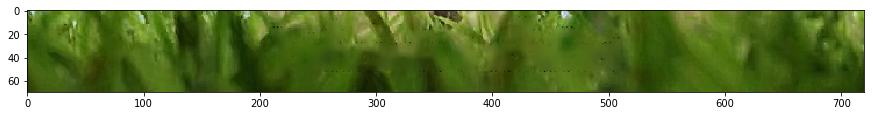

In [18]:
tofix_image = subtitle_frame.copy()
fixed_image = cv2.inpaint(tofix_image,subtitle_stoke,inpaint_width,cv2.INPAINT_TELEA)
plt.imshow(fixed_image)
plt.show() #save_post_inpaint

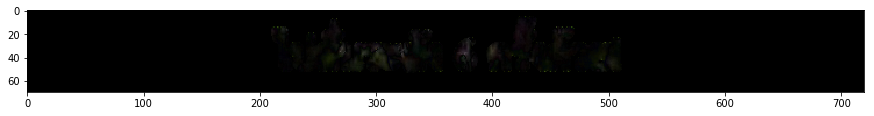

In [19]:
#เปรียบเทียบความต่างของ inpaint
difference_frame = cv2.absdiff(fixed_image, original_frame)
plt.imshow(difference_frame)
plt.show()

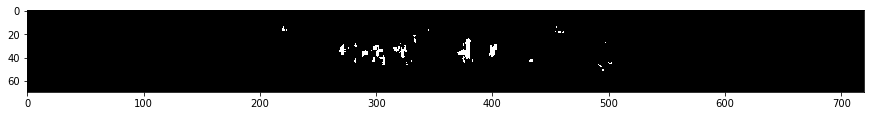

In [20]:
#ค่าพิเซลต่างจากพิกเซลเดิมเกิน 20
bw_difference_frame = cv2.inRange(difference_frame,(20,20,20),(255,255,255));
plt.imshow(bw_difference_frame,cmap = plt.cm.gray)
plt.show() #save_inpaint_diff

In [83]:
#พิมพ์จำนวนพิกเซลที่ต่างกัน
print(cv2.countNonZero(bw_difference_frame)) 

375
